## Name - Sandipan Majhi (24AI60R21) , Aayush Sugandh (24AI60R04)

In [1]:
# install required packages here
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00


In [2]:
# import required packages here
import os
import torch
import scipy
import argparse
import seaborn
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import train_test_split
from torch_geometric.utils import to_dense_adj
from torch.utils.data import DataLoader, random_split

### GCN Layer As per Kipf et al ###

In [4]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, use_bn = True):
        super().__init__()
        self.fc_layer = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.use_bn = use_bn

        nn.init.xavier_uniform_(self.fc_layer.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x, adj):
        """
            x : shape = (B, Nodes, num_features)
            adj : shape = (B, Nodes, Nodes)
        """
        num_batches = x.shape[0]

        self_loops = torch.eye(adj.shape[1]).cuda()
        adj = adj + self_loops

        neighbours = torch.sum(adj, dim = -1) ### Count Neighbours
        neighbour_inv = torch.pow(neighbours, -0.5) ## Inverse of sqrt of Neighbours
        neighbour_inv = torch.stack([torch.diag(neighbour_inv[b]) for b in range(num_batches)]) ## Batched Degree Matrix
        adj = torch.bmm(torch.bmm(neighbour_inv, adj), neighbour_inv) ### Normalized Adjacency Matrix

        #### Feature Projection ####
        x_ = torch.bmm(adj, x)

        x_ = self.fc_layer(x_)

        if self.use_bn:
            self.bn1 = nn.BatchNorm1d(x.shape[1]).to("cuda") ### Add BatchNorm
            x_ = self.bn1(x_)

        x_ = torch.nn.functional.normalize(x_, dim = 2)
        x_ = self.relu(x_)

        return x_

### GPool Layer as in Graph Unets ###

arguments : k (fraction of downsampling) \
in_features : input feature space dim

In [5]:
class GpoolLayer(nn.Module):
    def __init__(self, in_features, k):
        super().__init__()

        self.k = k

        p = torch.randn(in_features)
        self.p = nn.Parameter(p, requires_grad=True)
        self.sig = nn.Sigmoid()


    def forward(self, x, adj):
        """
            x shape : (B, num_nodes, num_features)
            adj : (B, num_nodes, num_nodes)
        """
        num_batches = x.shape[0]

        y = torch.matmul(x, self.p) ## y shape : (B, Nodes)
#         y = y / torch.norm(self.p) ### divide by norm
        y = y / torch.norm(self.p.detach()) ### divide by norm

        num_nodes_select = int(self.k * adj.shape[-1]) ### topk size
        nodes_selected = torch.topk(y, num_nodes_select)[1] ### Select top-k nodes

        y_hat = torch.stack([y[b, nodes_selected[b]] for b in range(num_batches)]) ### create y_hat matrix
        y_hat = self.sig(y_hat) ### apply sigmoid
        x_hat = torch.stack([x[b, nodes_selected[b],:] for b in range(num_batches)]) ### select nodes in x
        adj_hat = torch.stack([adj[b, nodes_selected[b]][:,nodes_selected[b]] for b in range(num_batches)]) ### select nodes in adj

        x_hat = torch.mul(x_hat, y_hat.unsqueeze(dim = 2)) ### element wise multiplcation of y_hat and x_hat

        return x_hat, adj_hat

## DiffPool Implementation ##

in_features : input feature space \
hidden_features : embedding space dimension in diffpool \
m : num_clusters

In [6]:
class DiffPool(nn.Module):
    def __init__(self, in_features, hidden_features, m):
        super().__init__()
        self.m = m

        self.embedding_layer = GCN(in_features, hidden_features)
        self.pool = GCN(in_features, m)

        self.soft = nn.Softmax(dim = -1)

    def forward(self, x, adj):
        """
            x shape : (B, num_nodes, num_features)
            adj : (B, num_nodes, num_nodes)
        """

        x_ = self.embedding_layer(x,adj) ### B, num_nodes, hidden_features
        s = self.pool(x,adj) ### B, num_nodes, m
        s = self.soft(s) ### Softmax applied on m dimension

        x = torch.bmm(torch.transpose(s, dim0 = 2, dim1 = 1), x_) ### New Cluster Features
        adj = torch.bmm(torch.transpose(s, dim0 = 2, dim1 = 1), torch.bmm(adj, s)) ### New Adjacency Matrix

        return x, adj



### Proposed Model as per assignment ###

Input -> GCN -> GCN -> Gpool + Diff Pool -> GCN -> GCN -> Gpool + Diff pool -> Classifier -> Loss

Our simple modification -> Skip connections between GCN layers as suggested by Kipf el al for deep GNNs. We also add a layer norm to this to stabilize training.

In [7]:
class GNNandPool(nn.Module):
    def __init__(self, in_features, out_features, dropout = 0.1, device = "cpu", **kwargs):
        super().__init__()
        self.device = device
        self.out_features = out_features

        self.layernorm1 = nn.LayerNorm(32)
        self.layernorm2 = nn.LayerNorm(32)

        self.gcn1 = GCN(in_features, 32)
        self.gcn2 = GCN(32, 32)

        self.gpool1 = GpoolLayer(32, float(kwargs.get('k_1')))
        self.gpool2 = GpoolLayer(32, float(kwargs.get('k_2')))

        self.gcn3 = GCN(32, 32)
        self.gcn4 = GCN(32, 32)

        self.dpool1 = DiffPool(in_features = 32, hidden_features= 32, m =  int(kwargs.get('m_1')))
        self.dpool2 = DiffPool(in_features = 32, hidden_features= 32, m = int(kwargs.get('m_2')))

        self.fc_layer = nn.Sequential(
                nn.Linear(96,32),
                nn.ReLU(),
                nn.Linear(32, self.out_features)
        )

        self.dropout_layer = nn.Dropout(dropout)


    def forward(self, x, adj):
        """
            x  : (B, num_nodes, num_features)
            adj : (B, num_nodes, num_nodes)
        """

        #### GNN Layers ####

        x1 = self.gcn1(x, adj)
        x2 = self.gcn2(x1, adj)

        #### Skip Connect suggested by Kipf et al in Appendix ####
        x2 = x2 + x1
        x2 = self.layernorm1(x2)


        xp1, adjp1 = self.gpool1(x2, adj)
        xp1, adjp1 = self.dpool1(xp1, adjp1)

        x3 = self.gcn3(xp1, adjp1)
        x4 = self.gcn4(x3, adjp1)

        #### Skip Connect suggested by Kipf et al in Appendix ####
        x4 = x3 + x4
        x4 = self.layernorm2(x4)

        xp2, adjp2 = self.gpool2(x4, adjp1)
        xp2, adjp2 = self.dpool2(xp2, adjp2)


        #### Dropout Layer ####
        xp2 = self.dropout_layer(xp2)
        xp2 = xp2.reshape(xp2.shape[0], -1)

#         print(xp2.shape)

        #### Fully Connected Classification Head ####
        xp2 = self.fc_layer(xp2)

        return xp2

## Data Collator ##

This collater incorporates and pads features and adjancency matrices into single batches.

In [9]:
class Collate:
    def __init__(self, device, max_nodes):
        self.device = device
        self.max_nodes = max_nodes

    def __call__(self, batch):
        adjs = []
        x = []
        y = []

        max_num_nodes = max([item.x.shape[0] for item in batch])

        for data in batch:
            features = data.x
            labels = data.y
            A = to_dense_adj(data.edge_index)
            A = torch.squeeze(A, dim = 0)


            pad_A = (0, max_num_nodes - A.shape[1], 0, max_num_nodes - A.shape[0])
            A = torch.nn.functional.pad(A, pad_A )

            pad_features = (0,0, 0,max_num_nodes - features.shape[0])
            features = torch.nn.functional.pad(features, pad_features)

            adjs.append(A)
            x.append(features)
            y.append(labels)


        adjs = torch.stack(adjs, dim = 0).to(self.device)
        x = torch.stack(x, dim = 0).to(self.device)
        y = torch.stack(y, dim = 0).to(self.device)


        return x, adjs, y


# Enzymes Dataset Experiments #

In [11]:
#### Enzymes Dataset Experiments

dataset = TUDataset(root='/content/ENZYMES',name = 'ENZYMES')

Processing...
Done!


In [ ]:
#### Preprocess and maintain loaders ####

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 256
max_nodes = max([data.x.shape[0] for data in dataset])

train_size = int(len(dataset) * 0.8)
test_size = (len(dataset) - train_size) // 2
val_size = len(dataset) - test_size - train_size

out_features = 6
train_, test_, val_ = random_split(dataset, (train_size, test_size, val_size))

trainloader = DataLoader(train_, batch_size= batch_size, shuffle=True, collate_fn=Collate(device, max_nodes))
testloader = DataLoader(test_, batch_size = batch_size, shuffle= False, collate_fn=Collate(device, max_nodes))
valloader = DataLoader(val_, batch_size = batch_size, shuffle= False, collate_fn=Collate(device, max_nodes))


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle as pkl

def trainandevaluate(model, train_loader, val_loader, test_loader, epochs, loss_fn, optimizer, device = "cpu", history = None):

  ##### History saver for losses and best model checkpoint #####
    training_history = {
        "train" : {
            "loss" : [],
            "acc" : [],
            "best_model_checkpoint" : None,
            "best_epoch" : None
          },
        "val" : {
            "loss" : [],
            "acc" : []
          },
        "test" : {
            "loss" : [],
            "acc" : []
          }
    }

    ##### Start Epochs #####
    for epoch in tqdm(range(epochs), total=epochs):
    ### Set up model for training ###
        model.train()

        train_loss = []
        val_loss = []
        test_loss = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        test_targets = []
        test_preds = []

        ### Iterate over train loader for training ###
        for batch in train_loader:
          ### set up optimizer to zero grad ###
            optimizer.zero_grad()

            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_targets.extend(y.cpu().tolist())
            train_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        for batch in val_loader:
            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)

            val_loss.append(loss.item())
            val_targets.extend(y.cpu().tolist())
            val_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        val_acc = accuracy_score(val_targets, val_preds)

        model.eval()
        for batch in test_loader:
            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)

            test_loss.append(loss.item())
            test_targets.extend(y.cpu().tolist())
            test_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        test_acc = accuracy_score(test_targets, test_preds)


        if len(training_history["test"]["acc"]) > 1 and test_acc > max(training_history["test"]["acc"]):
#             print("Saving Best Checkpoint Model")
            training_history["train"]["best_model_checkpoint"] = model.state_dict()
            training_history["train"]["best_epoch"] = epoch

        training_history["train"]["acc"].append(train_acc)
        training_history["train"]["loss"].append(np.mean(train_loss))

        training_history["val"]["acc"].append(val_acc)
        training_history["val"]["loss"].append(np.mean(val_loss))

        training_history["test"]["acc"].append(test_acc)
        training_history["test"]["loss"].append(np.mean(test_loss))

#         print(f"Epoch {epoch} / {epochs} ---- Training Loss = {training_history['train']['loss'][-1]}  ----- TrainingAcc = {training_history['train']['acc'][-1]}")
#         print(f"Epoch {epoch} / {epochs} ---- Val Loss = {training_history['val']['loss'][-1]}  ----- ValAcc = {training_history['val']['acc'][-1]}")
#         print(f"Epoch {epoch} / {epochs} ---- Test Loss = {training_history['test']['loss'][-1]}  ----- TestAcc = {training_history['test']['acc'][-1]}")

    return training_history


In [ ]:
###### Experiments ran on Enzymes Dataset #####

histories = {}

epochs = 1000

k1 = [0.9, 0.8, 0.6]
k2 = [0.9, 0.8, 0.6]

m_1 = 6
m_2 = 3

for gp1 in k1:
    for gp2 in k2:
        model = GNNandPool(in_features=3, out_features= out_features, k_1 = gp1, k_2 = gp2, m_1 = m_1, m_2 = m_2, device = device)
        model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr= 0.005, weight_decay=5e-4)
        training_history = trainandevaluate(model = model, train_loader = trainloader, val_loader = valloader, test_loader = testloader,
                                    epochs = 1000, loss_fn = loss_fn, optimizer = optimizer, device = device)

        #### Save History ####
        histories[(gp1,gp2)] = training_history

        #### Getting average test accuracy over top 10 models based in validation set accuracy ####
        topk_num = 10
        val_stat_tensor = torch.FloatTensor(training_history["val"]["acc"])
        test_stat_tensor = torch.FloatTensor(training_history["test"]["acc"])
        _, indices = torch.topk(val_stat_tensor, k=topk_num)

        print(f"------------Model setting k_1 = {gp1}, k_2 = {gp2}, m_1 = 6, m_2 = 3--------------")
        print(f"Top 10 model test accuracy scores = {test_stat_tensor[indices]}")
        print(f"Maximum Test accuracy achieved = {torch.max(test_stat_tensor[indices])}")
        print(f"Mean Test accuracy achieved = {torch.mean(test_stat_tensor[indices])}")
        print(f"Std Deviation of Test accuracy achieved = {torch.std(test_stat_tensor[indices])}")





100%|██████████| 1000/1000 [15:24<00:00,  1.08it/s]


------------Model setting k_1 = 0.9, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.5667, 0.5667, 0.5333, 0.5333, 0.5833, 0.5667, 0.5833, 0.5500, 0.5000,
        0.5167])
Maximum Test accuracy achieved = 0.5833333134651184
Mean Test accuracy achieved = 0.550000011920929
Std Deviation of Test accuracy achieved = 0.028327878564596176


100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]


------------Model setting k_1 = 0.9, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.5000, 0.4833, 0.4500, 0.5833, 0.5167, 0.4333, 0.4500, 0.4500, 0.4500,
        0.4667])
Maximum Test accuracy achieved = 0.5833333134651184
Mean Test accuracy achieved = 0.4783332943916321
Std Deviation of Test accuracy achieved = 0.045167721807956696


100%|██████████| 1000/1000 [15:20<00:00,  1.09it/s]


------------Model setting k_1 = 0.9, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.4667, 0.4667, 0.4667, 0.4500, 0.4000, 0.4667, 0.4000, 0.4500, 0.4833,
        0.4500])
Maximum Test accuracy achieved = 0.4833333194255829
Mean Test accuracy achieved = 0.44999998807907104
Std Deviation of Test accuracy achieved = 0.028327882289886475


100%|██████████| 1000/1000 [15:32<00:00,  1.07it/s]


------------Model setting k_1 = 0.8, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.5333, 0.5667, 0.5333, 0.6167, 0.5167, 0.5500, 0.5000, 0.6000, 0.5500,
        0.5667])
Maximum Test accuracy achieved = 0.6166666746139526
Mean Test accuracy achieved = 0.5533333420753479
Std Deviation of Test accuracy achieved = 0.03583225980401039


100%|██████████| 1000/1000 [15:28<00:00,  1.08it/s]


------------Model setting k_1 = 0.8, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.3000, 0.3500, 0.3833, 0.4000, 0.3333, 0.3833, 0.4000, 0.4167, 0.4333,
        0.3833])
Maximum Test accuracy achieved = 0.4333333373069763
Mean Test accuracy achieved = 0.37833335995674133
Std Deviation of Test accuracy achieved = 0.040100179612636566


100%|██████████| 1000/1000 [15:52<00:00,  1.05it/s]


------------Model setting k_1 = 0.8, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.5000, 0.4833, 0.4000, 0.4333, 0.4833, 0.4167, 0.4667, 0.4500, 0.4833,
        0.4500])
Maximum Test accuracy achieved = 0.5
Mean Test accuracy achieved = 0.45666664838790894
Std Deviation of Test accuracy achieved = 0.03258417174220085


100%|██████████| 1000/1000 [15:38<00:00,  1.07it/s]


------------Model setting k_1 = 0.6, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.4333, 0.4167, 0.4667, 0.4500, 0.3833, 0.3500, 0.4333, 0.2500, 0.3333,
        0.3833])
Maximum Test accuracy achieved = 0.46666666865348816
Mean Test accuracy achieved = 0.39000001549720764
Std Deviation of Test accuracy achieved = 0.0653575137257576


100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


------------Model setting k_1 = 0.6, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.3000, 0.2167, 0.2833, 0.2833, 0.2167, 0.2833, 0.3167, 0.2500, 0.2333,
        0.2000])
Maximum Test accuracy achieved = 0.3166666626930237
Mean Test accuracy achieved = 0.25833332538604736
Std Deviation of Test accuracy achieved = 0.04025382176041603


100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s]

------------Model setting k_1 = 0.6, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.5167, 0.4667, 0.5500, 0.4000, 0.4833, 0.4667, 0.5500, 0.5000, 0.4667,
        0.4667])
Maximum Test accuracy achieved = 0.550000011920929
Mean Test accuracy achieved = 0.4866666793823242
Std Deviation of Test accuracy achieved = 0.04499657079577446


In [ ]:
for gp1 in k1:
    for gp2 in k2:
        print(f"Model k_1 = {gp1} k_2 = {gp2} m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = {max(histories[(gp1, gp2)]['test']['acc'])}")

Model k_1 = 0.9 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.6333333333333333
Model k_1 = 0.9 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.6
Model k_1 = 0.9 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.5333333333333333
Model k_1 = 0.8 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.6666666666666666
Model k_1 = 0.8 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.5166666666666667
Model k_1 = 0.8 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.6
Model k_1 = 0.6 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.5333333333333333
Model k_1 = 0.6 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.4166666666666667
Model k_1 = 0.6 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 1000 epochs = 0.5666666666666667


## Model Training Results on 1000 epochs ##
## Dataset - Enzyme ##

```
Batch Size = 256
Learning Rate = 0.005
weight decay = 5 x 10^-4
Optimizer = Adam
Epochs 1000
```

> The following table shows us the Test Acc statistic of the proposed model. The Mean test statistic and std deviation of Test acc is calculated from `top 10 models sorted based on Validation Accuracy`.

> The Max Test Acc in 1000 Epochs is best Test Acc in training.



| k_1  | k_2  | m_1 | m_2 | Mean Test Acc ± Stdev Test Acc | Max Test Acc | Max Test Acc in 1000 Epochs |
|------|------|-----|-----|-------------------------------|--------------|-----------------------------|
| 0.9  | 0.9  | 6   | 3   | 0.5500 ± 0.0283               | 0.5833       | 0.6333                      |
| 0.9  | 0.8  | 6   | 3   | 0.4783 ± 0.0452               | 0.5833       | 0.6000                      |
| 0.9  | 0.6  | 6   | 3   | 0.4500 ± 0.0283               | 0.4833       | 0.5333                      |
| 0.8  | 0.9  | 6   | 3   | **0.5533 ± 0.0358**               | **0.6167**       | **0.6667**                      |
| 0.8  | 0.8  | 6   | 3   | 0.3783 ± 0.0401               | 0.4333       | 0.5167                      |
| 0.8  | 0.6  | 6   | 3   | 0.4567 ± 0.0326               | 0.5000       | 0.6000                      |
| 0.6  | 0.9  | 6   | 3   | 0.3900 ± 0.0654               | 0.4667       | 0.5333                      |
| 0.6  | 0.8  | 6   | 3   | 0.2583 ± 0.0403               | 0.3167       | 0.4167                      |
| 0.6  | 0.6  | 6   | 3   | 0.4867 ± 0.0450               | 0.5500       | 0.5667                      |


## It is clear that from the above that, k_1 = 0.8, k_2 = 0.9, m = 6 and m = 3 is the best model setting for this problem.


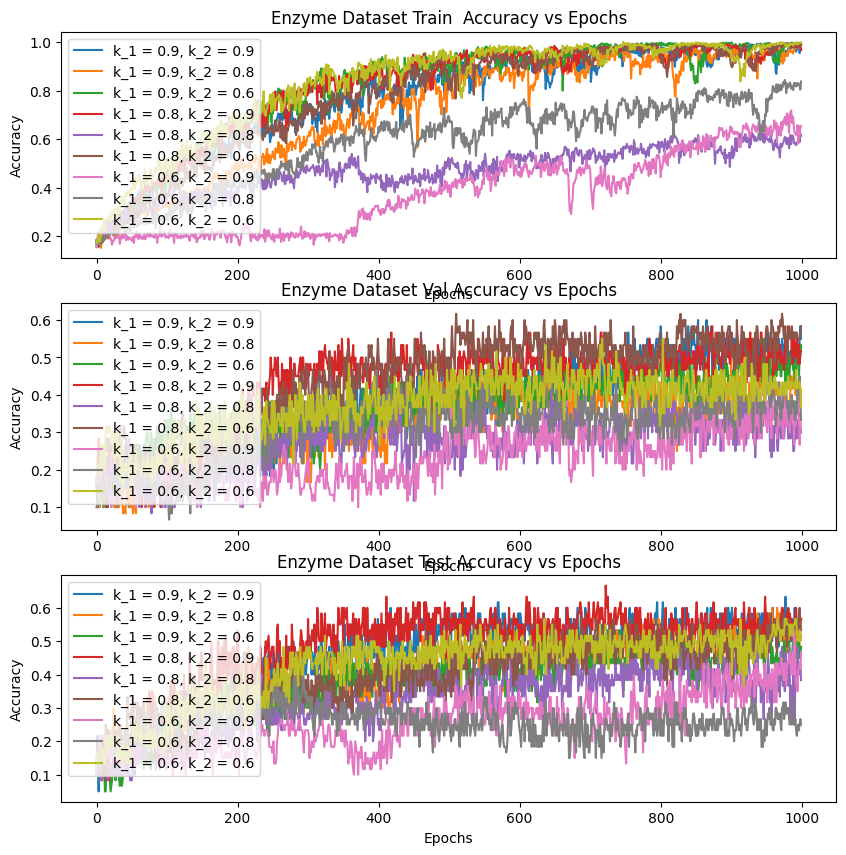

In [7]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(nrows=3, ncols=1, figsize = (10,10))


ax[0].plot([i for i in range(1000)], histories[(0.9,0.9)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[0].plot([i for i in range(1000)], histories[(0.9,0.8)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[0].plot([i for i in range(1000)], histories[(0.9,0.6)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[0].plot([i for i in range(1000)], histories[(0.8,0.9)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[0].plot([i for i in range(1000)], histories[(0.8,0.8)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[0].plot([i for i in range(1000)], histories[(0.8,0.6)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[0].plot([i for i in range(1000)], histories[(0.6,0.9)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[0].plot([i for i in range(1000)], histories[(0.6,0.8)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[0].plot([i for i in range(1000)], histories[(0.6,0.6)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[0].set_title("Enzyme Dataset Train  Accuracy vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc = "upper left")

ax[1].plot([i for i in range(1000)], histories[(0.9,0.9)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[1].plot([i for i in range(1000)], histories[(0.9,0.8)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[1].plot([i for i in range(1000)], histories[(0.9,0.6)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[1].plot([i for i in range(1000)], histories[(0.8,0.9)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[1].plot([i for i in range(1000)], histories[(0.8,0.8)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[1].plot([i for i in range(1000)], histories[(0.8,0.6)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[1].plot([i for i in range(1000)], histories[(0.6,0.9)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[1].plot([i for i in range(1000)], histories[(0.6,0.8)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[1].plot([i for i in range(1000)], histories[(0.6,0.6)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[1].set_title("Enzyme Dataset Val Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc = "upper left")

ax[2].plot([i for i in range(1000)], histories[(0.9,0.9)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[2].plot([i for i in range(1000)], histories[(0.9,0.8)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[2].plot([i for i in range(1000)], histories[(0.9,0.6)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[2].plot([i for i in range(1000)], histories[(0.8,0.9)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[2].plot([i for i in range(1000)], histories[(0.8,0.8)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[2].plot([i for i in range(1000)], histories[(0.8,0.6)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[2].plot([i for i in range(1000)], histories[(0.6,0.9)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[2].plot([i for i in range(1000)], histories[(0.6,0.8)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[2].plot([i for i in range(1000)], histories[(0.6,0.6)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[2].set_title("Enzyme Dataset Test Accuracy vs Epochs")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy")
ax[2].legend(loc = "upper left")


# D&D Dataset Experiments #

In [12]:
#### DD Dataset Experiments

dataset = TUDataset(root='/content/DD',name = 'DD')

Processing...
Done!


In [ ]:
#### Preprocess and maintain loaders ####

device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 8
max_nodes = max([data.x.shape[0] for data in dataset])

train_size = int(len(dataset) * 0.8)
test_size = (len(dataset) - train_size) // 2
val_size = len(dataset) - test_size - train_size

out_features = 2
train_, test_, val_ = random_split(dataset, (train_size, test_size, val_size))

trainloader = DataLoader(train_, batch_size= batch_size, shuffle=True, collate_fn=Collate(device, max_nodes))
testloader = DataLoader(test_, batch_size = batch_size, shuffle= False, collate_fn=Collate(device, max_nodes))
valloader = DataLoader(val_, batch_size = batch_size, shuffle= False, collate_fn=Collate(device, max_nodes))


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pickle as pkl

def trainandevaluate(model, train_loader, val_loader, test_loader, epochs, loss_fn, optimizer, device = "cpu", history = None):

  ##### History saver for losses and best model checkpoint #####
    training_history = {
        "train" : {
            "loss" : [],
            "acc" : [],
            "best_model_checkpoint" : None,
            "best_epoch" : None
          },
        "val" : {
            "loss" : [],
            "acc" : []
          },
        "test" : {
            "loss" : [],
            "acc" : []
          }
    }

    ##### Start Epochs #####
    for epoch in tqdm(range(epochs), total=epochs):
    ### Set up model for training ###
        model.train()

        train_loss = []
        val_loss = []
        test_loss = []

        train_preds = []
        train_targets = []

        val_preds = []
        val_targets = []

        test_targets = []
        test_preds = []

        ### Iterate over train loader for training ###
        for batch in train_loader:
          ### set up optimizer to zero grad ###
            optimizer.zero_grad()

            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_targets.extend(y.cpu().tolist())
            train_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        for batch in val_loader:
            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)

            val_loss.append(loss.item())
            val_targets.extend(y.cpu().tolist())
            val_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        val_acc = accuracy_score(val_targets, val_preds)

        model.eval()
        for batch in test_loader:
            x = batch[0]
            adj = batch[1]
            y = batch[2].squeeze(dim = -1)

            ### Get Predictions and loss ###
            predictions = model(x, adj)
            loss = loss_fn(predictions, y)

            test_loss.append(loss.item())
            test_targets.extend(y.cpu().tolist())
            test_preds.extend(torch.argmax(predictions.detach().cpu(), dim = 1).tolist())

        test_acc = accuracy_score(test_targets, test_preds)


        if len(training_history["test"]["acc"]) > 1 and test_acc > max(training_history["test"]["acc"]):
#             print("Saving Best Checkpoint Model")
            training_history["train"]["best_model_checkpoint"] = model.state_dict()
            training_history["train"]["best_epoch"] = epoch

        training_history["train"]["acc"].append(train_acc)
        training_history["train"]["loss"].append(np.mean(train_loss))

        training_history["val"]["acc"].append(val_acc)
        training_history["val"]["loss"].append(np.mean(val_loss))

        training_history["test"]["acc"].append(test_acc)
        training_history["test"]["loss"].append(np.mean(test_loss))

#         print(f"Epoch {epoch} / {epochs} ---- Training Loss = {training_history['train']['loss'][-1]}  ----- TrainingAcc = {training_history['train']['acc'][-1]}")
#         print(f"Epoch {epoch} / {epochs} ---- Val Loss = {training_history['val']['loss'][-1]}  ----- ValAcc = {training_history['val']['acc'][-1]}")
#         print(f"Epoch {epoch} / {epochs} ---- Test Loss = {training_history['test']['loss'][-1]}  ----- TestAcc = {training_history['test']['acc'][-1]}")

    return training_history


In [ ]:
###### Experiments ran on DD`1 Dataset #####

histories = {}

epochs = 50

k1 = [0.9, 0.8, 0.6]
k2 = [0.9, 0.8, 0.6]

m_1 = 6
m_2 = 3

for gp1 in k1:
    for gp2 in k2:
        model = GNNandPool(in_features=89, out_features= out_features, k_1 = gp1, k_2 = gp2, m_1 = m_1, m_2 = m_2, device = device)
        model.to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr= 0.005, weight_decay=5e-4)
        training_history = trainandevaluate(model = model, train_loader = trainloader, val_loader = valloader, test_loader = testloader,
                                    epochs = epochs, loss_fn = loss_fn, optimizer = optimizer, device = device)

        #### Save History ####
        histories[(gp1,gp2)] = training_history

        #### Getting average test accuracy over top 10 models based in validation set accuracy ####
        topk_num = 10
        val_stat_tensor = torch.FloatTensor(training_history["val"]["acc"])
        test_stat_tensor = torch.FloatTensor(training_history["test"]["acc"])
        _, indices = torch.topk(val_stat_tensor, k=topk_num)

        print(f"------------Model setting k_1 = {gp1}, k_2 = {gp2}, m_1 = 6, m_2 = 3--------------")
        print(f"Top 10 model test accuracy scores = {test_stat_tensor[indices]}")
        print(f"Maximum Test accuracy achieved = {torch.max(test_stat_tensor[indices])}")
        print(f"Mean Test accuracy achieved = {torch.mean(test_stat_tensor[indices])}")
        print(f"Std Deviation of Test accuracy achieved = {torch.std(test_stat_tensor[indices])}")





100%|██████████| 50/50 [09:44<00:00, 11.68s/it]


------------Model setting k_1 = 0.9, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7458, 0.7627, 0.7627, 0.7203, 0.7542, 0.7712, 0.7373, 0.7458, 0.7373,
        0.7712])
Maximum Test accuracy achieved = 0.7711864113807678
Mean Test accuracy achieved = 0.7508474588394165
Std Deviation of Test accuracy achieved = 0.016568219289183617


100%|██████████| 50/50 [09:49<00:00, 11.80s/it]


------------Model setting k_1 = 0.9, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7373, 0.7627, 0.7542, 0.7712, 0.7373, 0.7797, 0.7627, 0.7627, 0.7458,
        0.7458])
Maximum Test accuracy achieved = 0.7796609997749329
Mean Test accuracy achieved = 0.7559322118759155
Std Deviation of Test accuracy achieved = 0.014292783103883266


100%|██████████| 50/50 [09:50<00:00, 11.81s/it]


------------Model setting k_1 = 0.9, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7542, 0.7458, 0.7712, 0.7458, 0.7373, 0.7458, 0.7542, 0.7542, 0.7458,
        0.7373])
Maximum Test accuracy achieved = 0.7711864113807678
Mean Test accuracy achieved = 0.7491525411605835
Std Deviation of Test accuracy achieved = 0.009947353973984718


100%|██████████| 50/50 [09:19<00:00, 11.18s/it]


------------Model setting k_1 = 0.8, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7542, 0.7458, 0.7373, 0.7542, 0.7627, 0.7712, 0.7797, 0.7712, 0.7712,
        0.7542])
Maximum Test accuracy achieved = 0.7796609997749329
Mean Test accuracy achieved = 0.760169506072998
Std Deviation of Test accuracy achieved = 0.01327983383089304


100%|██████████| 50/50 [09:15<00:00, 11.10s/it]


------------Model setting k_1 = 0.8, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7627, 0.7458, 0.7458, 0.7627, 0.7288, 0.7542, 0.7288, 0.7458, 0.7458,
        0.7542])
Maximum Test accuracy achieved = 0.7627118825912476
Mean Test accuracy achieved = 0.7474576830863953
Std Deviation of Test accuracy achieved = 0.01185094378888607


100%|██████████| 50/50 [09:11<00:00, 11.03s/it]


------------Model setting k_1 = 0.8, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7712, 0.7797, 0.7881, 0.7373, 0.7627, 0.8051, 0.8051, 0.7373, 0.7712,
        0.7627])
Maximum Test accuracy achieved = 0.805084764957428
Mean Test accuracy achieved = 0.7720338702201843
Std Deviation of Test accuracy achieved = 0.023785924538969994


100%|██████████| 50/50 [08:27<00:00, 10.16s/it]


------------Model setting k_1 = 0.6, k_2 = 0.9, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7542, 0.7458, 0.7542, 0.7458, 0.7627, 0.7542, 0.7627, 0.7458, 0.7966,
        0.7627])
Maximum Test accuracy achieved = 0.7966101765632629
Mean Test accuracy achieved = 0.7584746479988098
Std Deviation of Test accuracy achieved = 0.015080624260008335


100%|██████████| 50/50 [08:29<00:00, 10.19s/it]


------------Model setting k_1 = 0.6, k_2 = 0.8, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7119, 0.7034, 0.7119, 0.7458, 0.7458, 0.7288, 0.7373, 0.7203, 0.7627,
        0.7288])
Maximum Test accuracy achieved = 0.7627118825912476
Mean Test accuracy achieved = 0.7296610474586487
Std Deviation of Test accuracy achieved = 0.018502285704016685


100%|██████████| 50/50 [08:27<00:00, 10.14s/it]

------------Model setting k_1 = 0.6, k_2 = 0.6, m_1 = 6, m_2 = 3--------------
Top 10 model test accuracy scores = tensor([0.7627, 0.7627, 0.7627, 0.7712, 0.7627, 0.7542, 0.7627, 0.7542, 0.7627,
        0.7288])
Maximum Test accuracy achieved = 0.7711864113807678
Mean Test accuracy achieved = 0.758474588394165
Std Deviation of Test accuracy achieved = 0.011474622413516045


In [15]:
k1 = [0.9, 0.8, 0.6]
k2 = [0.9, 0.8, 0.6]

m_1 = 6
m_2 = 3

for gp1 in k1:
    for gp2 in k2:
        print(f"Model k_1 = {gp1} k_2 = {gp2} m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = {max(histories[(gp1, gp2)]['test']['acc'])}")

Model k_1 = 0.9 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.7966101694915254
Model k_1 = 0.9 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.8050847457627118
Model k_1 = 0.9 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.788135593220339
Model k_1 = 0.8 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.8050847457627118
Model k_1 = 0.8 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.788135593220339
Model k_1 = 0.8 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.8050847457627118
Model k_1 = 0.6 k_2 = 0.9 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.7966101694915254
Model k_1 = 0.6 k_2 = 0.8 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.788135593220339
Model k_1 = 0.6 k_2 = 0.6 m_1 = 6 m_2 = 3 ------- Maximum Test Accuracy in all 50 epochs = 0.8050847457627118


## Model Training Results on 50 epochs ##
## Dataset - D&D ##

```
Batch Size = 8
Learning Rate = 0.005
weight decay = 5 x 10^-4
Optimizer = Adam
Epochs 1000
```

> The following table shows us the Test Acc statistic of the proposed model. The Mean test statistic and std deviation of Test acc is calculated from `top 10 models sorted based on Validation Accuracy`.

> The Max Test Acc in 1000 Epochs is best Test Acc in training.



| k_1  | k_2  | m_1 | m_2 | Mean Test Acc ± Stdev Test Acc | Max Test Acc | Max Test Acc in 50 Epochs |
|------|------|-----|-----|-------------------------------|--------------|---------------------------|
| 0.9  | 0.9  | 6   | 3   | 0.7508 ± 0.0166               | 0.7712       | 0.7966                    |
| 0.9  | 0.8  | 6   | 3   | 0.7559 ± 0.0143               | 0.7797       | 0.8051                    |
| 0.9  | 0.6  | 6   | 3   | 0.7492 ± 0.0099               | 0.7712       | 0.7881                    |
| 0.8  | 0.9  | 6   | 3   | **0.7602 ± 0.0133**               | **0.7797**       | **0.8051**                    |
| 0.8  | 0.8  | 6   | 3   | 0.7475 ± 0.0119               | 0.7627       | 0.7881                    |
| 0.8  | 0.6  | 6   | 3   | 0.7720 ± 0.0238               | 0.8051       | 0.8051                    |
| 0.6  | 0.9  | 6   | 3   | 0.7585 ± 0.0151               | 0.7966       | 0.7966                    |
| 0.6  | 0.8  | 6   | 3   | 0.7297 ± 0.0185               | 0.7627       | 0.7881                    |
| 0.6  | 0.6  | 6   | 3   | 0.7585 ± 0.0115               | 0.7712       | 0.8051                    |


## It is clear that from the above that, k_1 = 0.8, k_2 = 0.9, m = 6 and m = 3 is the best model setting for this problem.





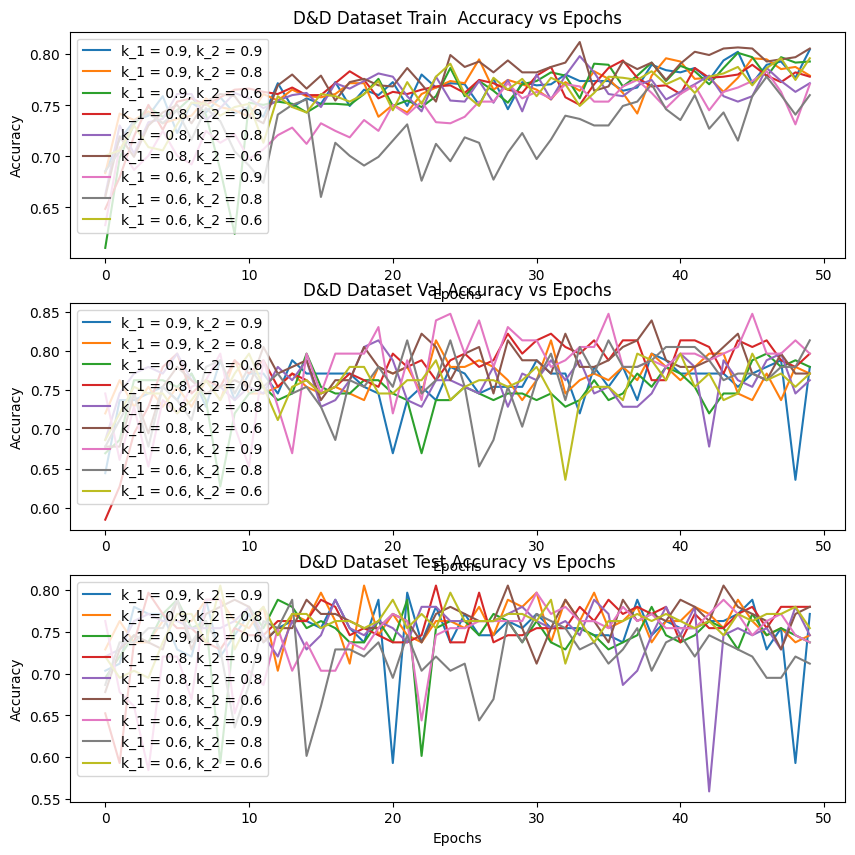

In [11]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(nrows=3, ncols=1, figsize = (10,10))


ax[0].plot([i for i in range(50)], histories[(0.9,0.9)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[0].plot([i for i in range(50)], histories[(0.9,0.8)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[0].plot([i for i in range(50)], histories[(0.9,0.6)]["train"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[0].plot([i for i in range(50)], histories[(0.8,0.9)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[0].plot([i for i in range(50)], histories[(0.8,0.8)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[0].plot([i for i in range(50)], histories[(0.8,0.6)]["train"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[0].plot([i for i in range(50)], histories[(0.6,0.9)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[0].plot([i for i in range(50)], histories[(0.6,0.8)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[0].plot([i for i in range(50)], histories[(0.6,0.6)]["train"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[0].set_title("D&D Dataset Train  Accuracy vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc = "upper left")

ax[1].plot([i for i in range(50)], histories[(0.9,0.9)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[1].plot([i for i in range(50)], histories[(0.9,0.8)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[1].plot([i for i in range(50)], histories[(0.9,0.6)]["val"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[1].plot([i for i in range(50)], histories[(0.8,0.9)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[1].plot([i for i in range(50)], histories[(0.8,0.8)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[1].plot([i for i in range(50)], histories[(0.8,0.6)]["val"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[1].plot([i for i in range(50)], histories[(0.6,0.9)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[1].plot([i for i in range(50)], histories[(0.6,0.8)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[1].plot([i for i in range(50)], histories[(0.6,0.6)]["val"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[1].set_title("D&D Dataset Val Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc = "upper left")

ax[2].plot([i for i in range(50)], histories[(0.9,0.9)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.9")
ax[2].plot([i for i in range(50)], histories[(0.9,0.8)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.8")
ax[2].plot([i for i in range(50)], histories[(0.9,0.6)]["test"]["acc"],  label = "k_1 = 0.9, k_2 = 0.6")
ax[2].plot([i for i in range(50)], histories[(0.8,0.9)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.9")
ax[2].plot([i for i in range(50)], histories[(0.8,0.8)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.8")
ax[2].plot([i for i in range(50)], histories[(0.8,0.6)]["test"]["acc"],  label = "k_1 = 0.8, k_2 = 0.6")
ax[2].plot([i for i in range(50)], histories[(0.6,0.9)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.9")
ax[2].plot([i for i in range(50)], histories[(0.6,0.8)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.8")
ax[2].plot([i for i in range(50)], histories[(0.6,0.6)]["test"]["acc"],  label = "k_1 = 0.6, k_2 = 0.6")
ax[2].set_title("D&D Dataset Test Accuracy vs Epochs")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy")
ax[2].legend(loc = "upper left")
